# Проект №11 - Численные методы

# Проект №11
## Cоздание модели оценки рыночной стоимости автомобиля

---

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

#### План
1. Загрузить и подготовить данные.
2. Обучить разные модели с различными гиперпараметрами.
3. Проанализировать скорость работы и качество моделей.

*Примечания:*
* Для оценки качества моделей применить метрику **RMSE**.
* Самостоятельно освоить библиотеку **LightGBM** и её средствами постройте **модели градиентного бустинга**.
* Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
* Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
* Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del:
*del features_train* 

# 1. Подготовка данных

## Импорт библиотек и установка базовых настроек

In [1]:
# import library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()

In [2]:
#Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

#базовые библиотеки машинного обучения
from scipy import stats as st 
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, r2_score, mean_absolute_error, make_scorer
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from catboost import CatBoostRegressor
import xgboost
import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit

In [3]:
import locale
locale.setlocale(locale.LC_ALL, '')

'en_US.UTF-8'

## Первичный анализ

In [4]:
df = pd.read_csv("/datasets/autos.csv")
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.tail(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [6]:
print('Количество дубликатов', df.duplicated().sum())
print('Количество записей до чистки дублей =',df.shape[0])
df = df.drop_duplicates().reset_index(drop=True)
print('Количество записей после чистки дублей =',df.shape[0])

Количество дубликатов 4
Количество записей до чистки дублей = 354369
Количество записей после чистки дублей = 354365


### Работа с пропусками

In [7]:
sp = pd.DataFrame((df.isna().sum()/df.shape[0]).round(2))
sp = sp[sp != 0].sort_values(by=0, ascending=False).head(5)
sp['describe'] = ['была машина в ремонте или нет',\
                  'тип автомобильного кузова',\
                  'тип топлива',\
                  'тип коробки передач',\
                  'модель автомобиля'\
                 ]
sp.columns = ['persent_nan', 'describe']
sp['count'] = sp['persent_nan']*df.shape[0]
sp

,persent_nan,describe,count
NotRepaired,0.20,была машина в ремонте или нет,70873.00
VehicleType,0.11,тип автомобильного кузова,38980.15
FuelType,0.09,тип топлива,31892.85
Gearbox,0.06,тип коробки передач,21261.90
Model,0.06,модель автомобиля,21261.90


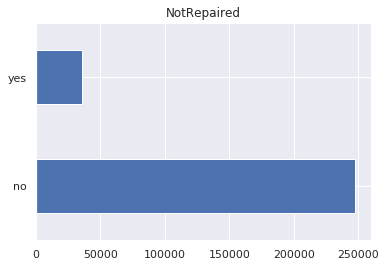

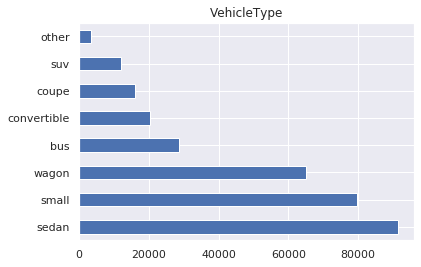

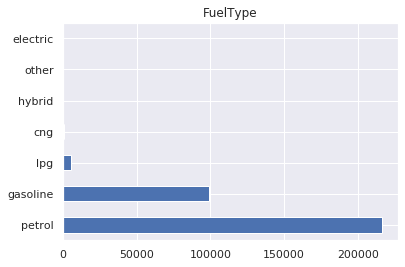

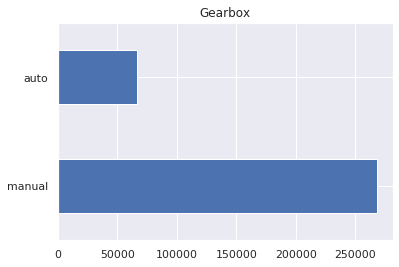

In [8]:
def plot(parametr):
    df[parametr].value_counts().plot(kind ='barh')
for i in list(sp.index)[:-1]:
    plt.title(i)
    plot(i)
    plt.show()
    

In [9]:
df['Model'].value_counts().head(10)

golf        29232
other       24420
3er         19761
polo        13066
corsa       12570
astra       10809
passat      10145
a4           9900
c_klasse     8312
5er          7868
Name: Model, dtype: int64

In [10]:
sp.index

Index(['NotRepaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model'], dtype='object')

In [11]:
df['NotRepaired'].fillna('no', inplace=True) # Замена сделана таким образом, т.к. автомобиль чаще не был в ремонте
df['VehicleType'].fillna('other', inplace=True) #данная категория, как раз обозначает тип авто,который не определен, что нам полностью подходит. Вероятнее всего стоит Nan, потому что человек создавший объявление пропустил данное поле по какой то причине.
df['FuelType'].fillna('petrol', inplace=True) # больше 90% всех автомабилей используют бензин
df['Gearbox'].fillna('manual', inplace=True) # это необходимый минимум для автомобиля, любая ругая коробка передач, только улучшает стоимость авто
df['Model'].fillna('other', inplace=True)# По аналогии с типом. Также возможно, что там где ринимались объявления не было предложенно нужной марки или данные не были записаны.

In [12]:
pd.DataFrame((df.isna().sum()/df.shape[0]).round(2)).T

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
DateCrawled          354365 non-null object
Price                354365 non-null int64
VehicleType          354365 non-null object
RegistrationYear     354365 non-null int64
Gearbox              354365 non-null object
Power                354365 non-null int64
Model                354365 non-null object
Kilometer            354365 non-null int64
RegistrationMonth    354365 non-null int64
FuelType             354365 non-null object
Brand                354365 non-null object
NotRepaired          354365 non-null object
DateCreated          354365 non-null object
NumberOfPictures     354365 non-null int64
PostalCode           354365 non-null int64
LastSeen             354365 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Необходимо привести даты к правильному типу:

In [15]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%d %H:%M:%S')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
DateCrawled          354365 non-null datetime64[ns]
Price                354365 non-null int64
VehicleType          354365 non-null object
RegistrationYear     354365 non-null int64
Gearbox              354365 non-null object
Power                354365 non-null int64
Model                354365 non-null object
Kilometer            354365 non-null int64
RegistrationMonth    354365 non-null int64
FuelType             354365 non-null object
Brand                354365 non-null object
NotRepaired          354365 non-null object
DateCreated          354365 non-null datetime64[ns]
NumberOfPictures     354365 non-null int64
PostalCode           354365 non-null int64
LastSeen             354365 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 43.3+ MB


### Повторная проверка на дубли

In [17]:
df.duplicated().sum()

1

In [18]:
df = df.drop_duplicates().reset_index(drop=True)
print(df.duplicated().sum())
df.head(3)

0


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14,0,90480,2016-04-05 12:47:46


#####  Вывод:
После восстановления данных, были обнаружены дубли и удаленны.

## EDA
Проведем иследовательский анализ на нахождение аномалий в датасете и выбросов

In [19]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354364.000000,354364.000000,354364.000000,354364.000000,354364.000000,354364.0,354364.000000
mean,4416.655608,2004.234471,110.093723,128211.373051,5.714641,0.0,50508.461698
std,4514.159690,90.228593,189.851590,37905.136957,3.726433,0.0,25783.124276
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49409.500000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


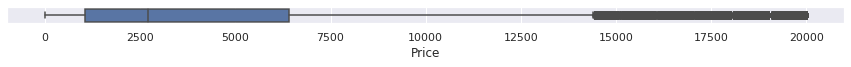

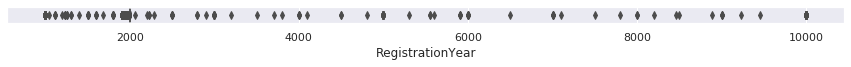

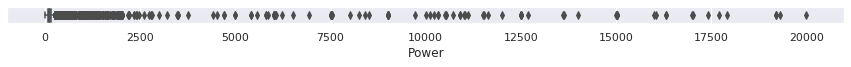

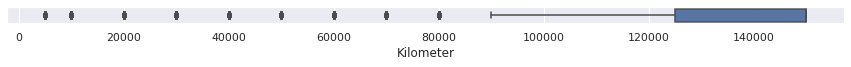

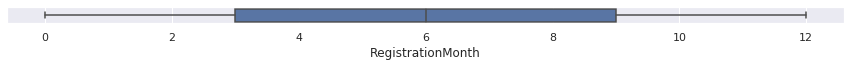

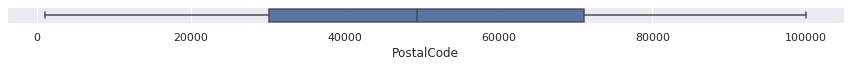

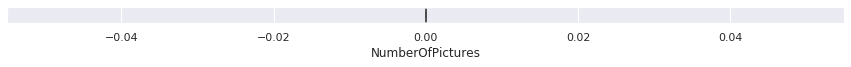

In [20]:
#Общая картина числовых признаков
for i in ['Price','RegistrationYear','Power','Kilometer','RegistrationMonth','PostalCode','NumberOfPictures']:
    plt.figure(figsize=(15,.3))
    sns.boxplot(df[i]);
    plt.show()

Очистим год регистрации от выбросов и некоректных данных, т.к. раритетные машины - 20 век, а самые новые не ранее 2020 года, все что не входит в данный промежуток - удалить.

Доля, удаляемых, данных = 0.0004825546613087108


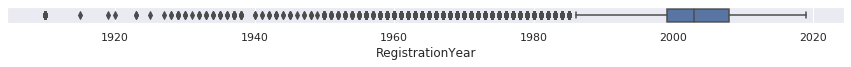

In [21]:
df_temp = df.copy().query('~(1900 < RegistrationYear < 2020)')
print('Доля, удаляемых, данных =', df_temp.shape[0]/df.shape[0])
df = df.query('1900 < RegistrationYear < 2020')
plt.figure(figsize=(15,.3))
sns.boxplot(df['RegistrationYear'])

In [22]:
print('Количество уникальных элементов -',df.NumberOfPictures.value_counts())
df[df['NumberOfPictures'] != 0]

Количество уникальных элементов - 0    354193
Name: NumberOfPictures, dtype: int64


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


Т.к. признак - количество фотографий - не используется, либо проблема кроется в неправильной выгрузке данных - влюбом случае эти данные не несут никакой информации, из чего следует их удаление.

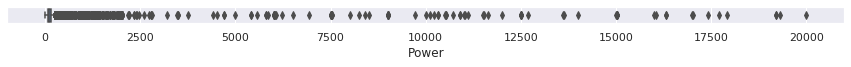

In [23]:
plt.figure(figsize=(15,.3))
sns.boxplot(df['Power'])

Распределение сложно получить, т.к. рассеянгость данных очень высокая. Сильно выделяются выбросы, проанализировав автомобильные сайты были полученны следующие данные, что максимально доступное количесво лошадиных сил порчдка 5000, 

In [24]:
print(df.loc[df['Power'] > 1000].count().max())
print(df['Power'].median())
df = df.query('Power < 1000')
df.loc[(df['Power'] == 0),'Power'] = df['Power'].median()

295
105.0


In [25]:
df.drop('NumberOfPictures', axis=1, inplace=True)
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,other,1993,manual,105.0,golf,150000,0,petrol,volkswagen,no,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.0,other,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,no,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21


Рассмотрим распределния признаков дискретных величин после чистки и восстановления данных

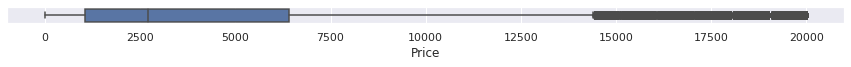

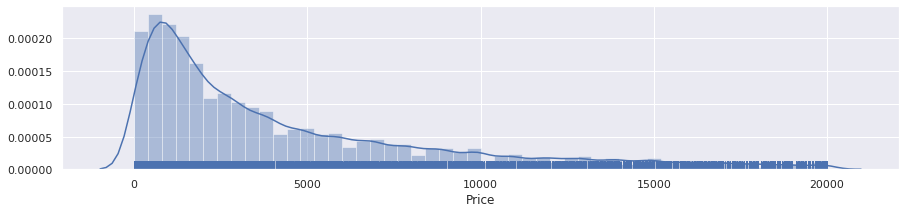

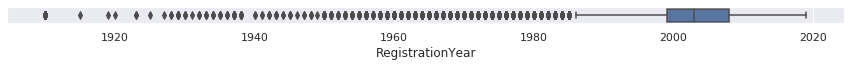

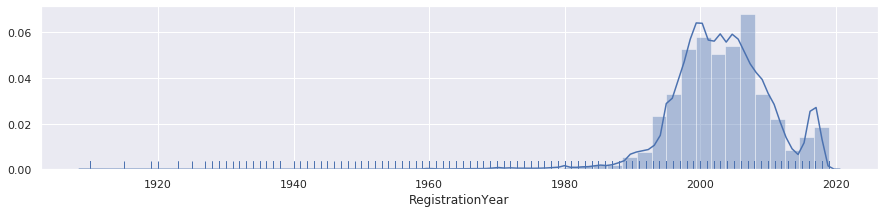

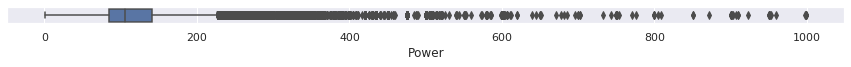

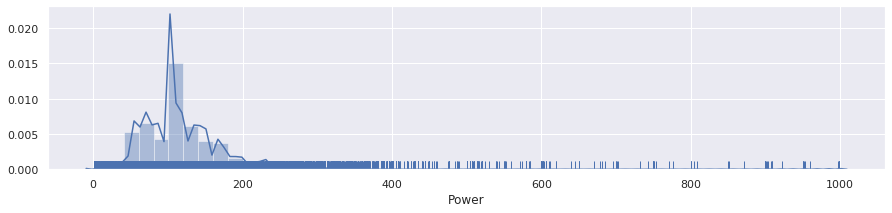

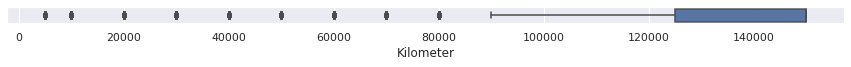

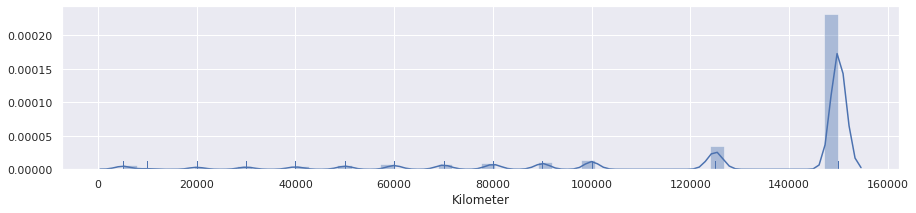

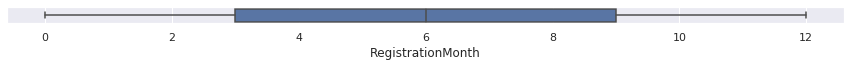

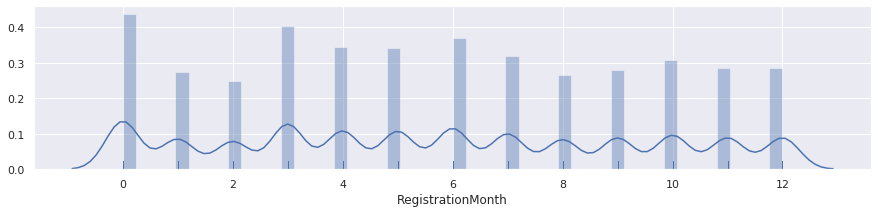

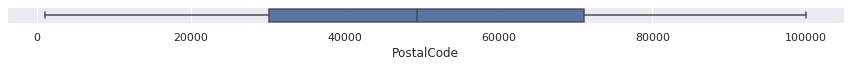

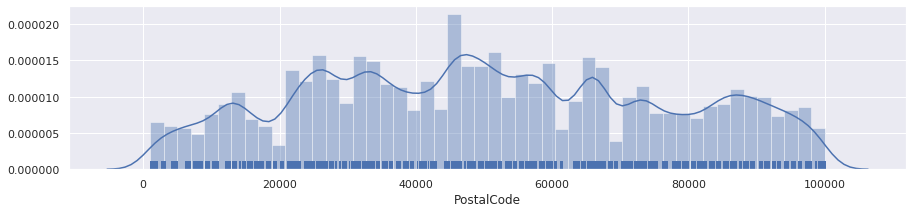

In [26]:
for i in ['Price','RegistrationYear','Power','Kilometer','RegistrationMonth','PostalCode']:
    plt.figure(figsize=(15,.3))
    sns.boxplot(df[i]);
    plt.show()
    plt.figure(figsize=(15,3))
    ax = sns.distplot(df[i], rug=True);
    plt.show()

## Дополнительная очистка признаков

In [27]:
df_temp_1 = df.copy()

In [28]:
#Сохраним временные данные
df_time = df[['DateCrawled','DateCreated','LastSeen']]

#Очистим сет от временных данных
df = df.drop(['DateCrawled','DateCreated','LastSeen'], axis=1)

In [29]:
df_temp_2 = df.copy()
df.PostalCode.value_counts()

10115    818
65428    612
66333    343
32257    317
44145    315
        ... 
9517       1
95367      1
55621      1
74937      1
37297      1
Name: PostalCode, Length: 8143, dtype: int64

Данные индексы - международные, у данных индексов сложно установить истинный город и страну, т.к. например индекс 95367 соответствует США, Германии, Индонезии, Литве и Мексике, что именно надо выбирать - не понятно. Ссылка на сайт по идентификации  <https://почтовые-индексы.cybo.com/search/?q=95367&tok=qcgzv7-e75a512d9957a36c2dfa&pl=&i=&t=> . Так как данный признак невозможно трактовать однозначно, он не может нести какую то бизнес информацию, вследствии чего - удаляем.

In [30]:
df.drop(['PostalCode'], axis=1, inplace = True)

In [31]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

## Вывод
Данные были очищенны от дубликатов, пропуски замененны на наимболее часто встречающиеся значения или значение **other**. Типы дынных соответствуют представленным признакам, но были определены типы данных у дат: **DateCrawled, DateCreated, LastSeen**. Удалены из сета данных признаки не позволяющие однозначно себя трактовать и временные ряды, т.к. модели не могут их обработать.

# 2. Обучение моделей

## Описание данных
### Признаки:
* DateCrawled — дата скачивания анкеты из базы. *Непрерывный признак - временной ряд*
* VehicleType — тип автомобильного кузова. *Категориальный*
* RegistrationYear — год регистрации автомобиля. *Категориальный* 
* Gearbox — тип коробки передач. *Категориальный - бинарный*
* Power — мощность (л. с.). *Дискретный*
* Model — модель автомобиля. *Категориальный*
* Kilometer — пробег (км). *Непрерывный, возможно представление в виде категориального признака* 
* RegistrationMonth — месяц регистрации автомобиля. *Категориальный* 
* FuelType — тип топлива. *Категориальный*
* Brand — марка автомобиля. *Категориальный*
* NotRepaired — была машина в ремонте или нет. *Категориальный - бинарный*
* DateCreated — дата создания анкеты. *Непрерывный признак - временной ряд*
* NumberOfPictures — количество фотографий автомобиля. *Дискретный*  
* PostalCode — почтовый индекс владельца анкеты (пользователя). *Дискретный* 
* LastSeen — дата последней активности пользователяю. *Непрерывный признак - временной ряд* 


### Целевой признак
* Price — цена (евро). *Дискретный* 

## Предобработка и выделение пространства рбучающих признаков и целевой метки
### Кодирование категориальных признаков (The Encoding of categorical features)
#### OneHotEncoder

Необходимо для линейной регресии и случайного леса

In [32]:
df_temp3 = df.copy() # сет данных до OneHotEncoder(OHE/ohe) -кодирования
data_ohe = pd.get_dummies(df, drop_first = True)
#data_ohe.head()

features_ohe = data_ohe.drop('Price',axis=1)
target_ohe = data_ohe['Price']

x_train_ohe, x_temp, y_train_ohe, y_temp = train_test_split(\
                                                    features_ohe, target_ohe,\
                                                    test_size=.3, random_state=12345)
x_test_ohe, x_valid_ohe, y_test_ohe, y_valid_ohe = train_test_split(\
                                                    x_temp, y_temp,\
                                                    test_size=.5, random_state=12345)

In [33]:
#Названия признаков
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
kol = list((set(df.columns)-set(['Price']))-set(categorical_features))

#### Ordinal Encoder (OE/oe)
Кодирование категориальных признаков для бустинговых моделей

In [34]:
from sklearn.preprocessing import OrdinalEncoder

df = df.reset_index(drop=True)
features = df.drop('Price',axis=1)
target = df['Price']

temp_0 = features[categorical_features]
enc = OrdinalEncoder(categories = 'auto')
temp = enc.fit_transform(temp_0)
#enc.categories_
features = pd.concat([pd.DataFrame(data = temp, columns = temp_0.columns), features[kol]],axis=1)
#pd.DataFrame(data = temp, columns = temp_0.columns)

In [35]:
features.tail(2)

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,RegistrationMonth,Power,Kilometer,RegistrationYear
353892,0.0,1.0,224.0,2.0,38.0,0.0,3,102.0,150000,1996
353893,7.0,1.0,116.0,2.0,38.0,0.0,6,100.0,150000,2002


##### Создаем выборки из датасета

In [36]:
x_train, x_temp, y_train, y_temp = train_test_split(\
                                                    features, target,\
                                                    test_size=.3, random_state=12345)
x_test, x_valid, y_test, y_valid = train_test_split(\
                                                    x_temp, y_temp,\
                                                    test_size=.5, random_state=12345)

In [37]:
#Проверка размеров
for i in [x_train, x_test, y_train, y_test, x_valid, y_valid]:
    print(i.shape)

(247725, 10)
(53084, 10)
(247725,)
(53084,)
(53085, 10)
(53085,)


# 3. Анализ моделей

## 3.1 Подготовка данных для обучения лин.регресии, деревом и случайным лесом

In [38]:
column_all_ohe = features_ohe.columns
column_all = features.columns
column_all_ohe

Index(['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
       'VehicleType_convertible', 'VehicleType_coupe', 'VehicleType_other',
       'VehicleType_sedan', 'VehicleType_small', 'VehicleType_suv',
       ...
       'Brand_skoda', 'Brand_smart', 'Brand_sonstige_autos', 'Brand_subaru',
       'Brand_suzuki', 'Brand_toyota', 'Brand_trabant', 'Brand_volkswagen',
       'Brand_volvo', 'NotRepaired_yes'],
      dtype='object', length=307)

### 3.1.1 Масштабирование

In [39]:
scaler_ohe = StandardScaler()
x_train_ohe = pd.DataFrame(data = scaler_ohe.fit_transform(x_train_ohe), columns = column_all_ohe)
x_test_ohe =  pd.DataFrame(data = scaler_ohe.transform(x_test_ohe), columns = column_all_ohe)
x_valid_ohe = pd.DataFrame(data = scaler_ohe.transform(x_valid_ohe), columns = column_all_ohe)
x_valid_ohe

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
0,-0.546307,-0.262424,0.575909,-1.267418,-0.247777,-0.218084,-0.359279,1.694493,-0.538609,-0.186224,...,-0.126587,-0.124212,-0.096764,-0.047042,-0.080500,-0.11456,-0.040115,-0.526413,-0.095352,-0.335985
1,-0.280415,0.993823,0.575909,-0.999106,-0.247777,-0.218084,-0.359279,1.694493,-0.538609,-0.186224,...,-0.126587,-0.124212,-0.096764,-0.047042,-0.080500,-0.11456,-0.040115,-0.526413,-0.095352,-0.335985
2,0.650208,0.993823,0.575909,-0.194168,-0.247777,-0.218084,-0.359279,-0.590147,-0.538609,-0.186224,...,-0.126587,-0.124212,-0.096764,-0.047042,-0.080500,-0.11456,-0.040115,-0.526413,-0.095352,-0.335985
3,0.251369,0.124114,0.575909,-0.999106,-0.247777,-0.218084,-0.359279,1.694493,-0.538609,-0.186224,...,-0.126587,-0.124212,-0.096764,-0.047042,-0.080500,-0.11456,-0.040115,-0.526413,-0.095352,-0.335985
4,1.713777,-0.262424,0.575909,-0.730793,-0.247777,-0.218084,2.783351,-0.590147,-0.538609,-0.186224,...,-0.126587,-0.124212,-0.096764,-0.047042,-0.080500,-0.11456,-0.040115,-0.526413,-0.095352,2.976327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53080,0.916100,0.993823,-0.084156,0.610769,-0.247777,-0.218084,-0.359279,1.694493,-0.538609,-0.186224,...,-0.126587,-0.124212,-0.096764,-0.047042,-0.080500,-0.11456,-0.040115,-0.526413,-0.095352,-0.335985
53081,-0.812200,-1.132133,-1.008247,-1.267418,-0.247777,-0.218084,-0.359279,-0.590147,1.856633,-0.186224,...,-0.126587,-0.124212,-0.096764,-0.047042,12.422298,-0.11456,-0.040115,-0.526413,-0.095352,2.976327
53082,-1.476930,0.278729,0.575909,0.610769,4.035885,-0.218084,-0.359279,-0.590147,-0.538609,-0.186224,...,-0.126587,-0.124212,-0.096764,-0.047042,-0.080500,-0.11456,-0.040115,-0.526413,-0.095352,-0.335985
53083,0.650208,1.129112,-0.744221,1.147394,-0.247777,-0.218084,-0.359279,1.694493,-0.538609,-0.186224,...,-0.126587,-0.124212,-0.096764,-0.047042,-0.080500,-0.11456,-0.040115,-0.526413,-0.095352,-0.335985


In [40]:
scaler = StandardScaler()
x_train = pd.DataFrame(data = scaler.fit_transform(x_train), columns = column_all)
x_test =  pd.DataFrame(data = scaler.transform(x_test), columns = column_all)
x_valid = pd.DataFrame(data = scaler.transform(x_valid), columns = column_all) 
x_valid

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,RegistrationMonth,Power,Kilometer,RegistrationYear
0,-0.070146,-2.083583,-0.760411,0.644016,-0.066810,-0.335985,-1.267418,-0.262424,0.575909,-0.546307
1,-0.070146,-2.083583,-1.447188,0.644016,-1.420176,-0.335985,-0.999106,0.993823,0.575909,-0.280415
2,1.408744,0.479942,-0.760411,-1.573365,-0.066810,-0.335985,-0.194168,0.993823,0.575909,0.650208
3,-0.070146,0.479942,-1.003645,0.644016,0.233938,-0.335985,-0.999106,0.124114,0.575909,0.251369
4,-0.563110,0.479942,0.741914,0.644016,0.233938,2.976327,-0.730793,-0.262424,0.575909,1.713777
...,...,...,...,...,...,...,...,...,...,...
53080,-0.070146,0.479942,0.398526,-1.573365,0.685060,-0.335985,0.610769,0.993823,-0.084156,0.916100
53081,0.422817,0.479942,0.770530,0.644016,1.060995,2.976327,-1.267418,-1.132133,-1.008247,-0.812200
53082,-1.549036,0.479942,0.770530,0.644016,-1.495363,-0.335985,0.610769,0.278729,0.575909,-1.476930
53083,-0.070146,-2.083583,1.843619,-1.573365,-1.420176,-0.335985,1.147394,1.129112,-0.744221,0.650208


# 3.2 Модели 

### 3.2.1 Линейная регрессия

In [41]:
%%time
model_linReg = LinearRegression()
model_linReg.fit(x_train_ohe, y_train_ohe)
predict_model_linReg = model_linReg.predict(x_test_ohe)
rmse_model_linReg = mse(y_test_ohe, predict_model_linReg)**(0.5)
mae_model_linReg = mean_absolute_error(y_test_ohe, predict_model_linReg)
print('rmse =', rmse_model_linReg)
print('mae =', mae_model_linReg)

rmse = 2758.5649621725124
mae = 1887.9663582745998
CPU times: user 21.7 s, sys: 5.77 s, total: 27.4 s
Wall time: 27.4 s


In [42]:
index_table = 0
table = pd.DataFrame(columns=['name','rmse','mae','total_time_in_seconds'])
index_table +=1
table.loc[index_table] = ['Linear Regression', rmse_model_linReg, mae_model_linReg, 26.4]
table

,name,rmse,mae,total_time_in_seconds
1,Linear Regression,2758.564962,1887.966358,26.4


### 3.2.2 Случайный лес

In [43]:
#Параметры для GridSearch
param_dist = {'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 100, num = 2)],
               #'max_features': ['log2', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(start = 1, stop = 100, num = 2)],
               #'min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 50, num = 25)],
               #'min_samples_leaf': [int(x) for x in np.linspace(start = 2, stop = 50, num = 25)],
               #'bootstrap': [True, False]
             }

#### 3.2.2.1 Random Forest Regressor (с тюнингом)

In [44]:
%%time

model_RandForest_t = RandomForestRegressor(random_state = 12345)

#Параметры для GridSearch
parametrs_grid = {'n_estimators': range(50, 100, 50),'max_depth' : range(50, 100, 50)}

grid_cv = GridSearchCV(model_RandForest_t, parametrs_grid)

grid_cv.fit(x_train_ohe, y_train_ohe)

print(grid_cv.best_params_)

predict_model_RandForest_tuning = grid_cv.predict(x_test_ohe)
rmse_model_RandForest_tuning = mse(y_test_ohe, predict_model_RandForest_tuning)**(0.5)
mae_model_RandForest_tuning = mean_absolute_error(y_test_ohe, predict_model_RandForest_tuning)

print('rmse =', rmse_model_RandForest_tuning)
print('mae =', mae_model_RandForest_tuning)

{'max_depth': 50, 'n_estimators': 50}
rmse = 1750.4866077207978
mae = 1013.6725985767088
CPU times: user 19min 22s, sys: 3.18 s, total: 19min 25s
Wall time: 19min 34s


In [ ]:
index_table +=1
table.loc[index_table] = ['Random Forest Regressor tuning',\
                          rmse_model_RandForest_tuning,\
                          mae_model_RandForest_tuning, 1724]
table

#### 3.2.2.2 Random Forest Regressor (дефолтные параметры)

In [45]:
%%time
model_RandForest = RandomForestRegressor()
model_RandForest.fit(x_train_ohe, y_train_ohe)
predict_model_RandForest = model_RandForest.predict(x_test_ohe)
rmse_model_RandForest = mse(y_test_ohe, predict_model_RandForest)**(0.5)
mae_model_RandForest = mean_absolute_error(y_test_ohe, predict_model_RandForest)
print('rmse =', rmse_model_RandForest)
print('mae =', mae_model_RandForest)

rmse = 1795.1734950301995
mae = 1044.0307228034887
CPU times: user 1min 19s, sys: 351 ms, total: 1min 20s
Wall time: 1min 21s


In [46]:
index_table +=1
table.loc[index_table] = ['Random Forest Regressor', rmse_model_RandForest, mae_model_RandForest, 81]
table

,name,rmse,mae,total_time_in_seconds
1,Linear Regression,2758.564962,1887.966358,26.4
2,Random Forest Regressor,1795.173495,1044.030723,74.0


In [56]:
%%time
model_RandForest_oe = RandomForestRegressor()
model_RandForest_oe.fit(x_train, y_train)
predict_model_RandForest_oe = model_RandForest_oe.predict(x_test)
rmse_model_RandForest_oe = mse(y_test, predict_model_RandForest_oe)**(0.5)
mae_model_RandForest_oe = mean_absolute_error(y_test, predict_model_RandForest_oe)
print('rmse =', rmse_model_RandForest_oe)
print('mae =', mae_model_RandForest_oe)

rmse = 1812.4046638130656
mae = 1061.650935157953
CPU times: user 11.6 s, sys: 198 ms, total: 11.8 s
Wall time: 11.8 s


In [57]:
index_table +=1
table.loc[index_table] = ['Random Forest Regressor OE', rmse_model_RandForest_oe, mae_model_RandForest_oe, 81]
table

,name,rmse,mae,total_time_in_seconds
1,Linear Regression,2758.564962,1887.966358,26.40
2,Random Forest Regressor,1795.173495,1044.030723,74.00
3,SGD Regressor (OE),3142.400687,2225.120049,0.97
4,Random Forest Regressor OE,1812.404664,1061.650935,81.00


### 3.2.3 SGD regressor

In [47]:
%%time
model_SGD = SGDRegressor()
model_SGD.fit(x_train_ohe, y_train_ohe)
predict_model_SGD = model_SGD.predict(x_test_ohe)
rmse_model_SGD = mse(y_test_ohe, predict_model_SGD)**(0.5)
mae_model_SGD = mean_absolute_error(y_test_ohe, predict_model_SGD)
print('rmse =', rmse_model_SGD)
print('mae =', mae_model_SGD)

rmse = 22551978784.743977
mae = 521700058.08233273
CPU times: user 4min 57s, sys: 279 ms, total: 4min 57s
Wall time: 4min 59s


SGD регрессор выдал ошибку в виде неправильных метрик rmse, mae, т.к. X было кодировано методикой OneHotEncoder. Рассмотрим, как будет работать модель с данными, где категориальные признаки были заменены методом OnEncoder.

In [48]:
%%time
model_SGD_oe = SGDRegressor(max_iter=100,)
model_SGD_oe.fit(x_train, y_train)
predict_model_SGD_oe = model_SGD_oe.predict(x_test)
rmse_model_SGD_oe = mse(y_test, predict_model_SGD_oe)**(0.5)
mae_model_SGD_oe = mean_absolute_error(y_test, predict_model_SGD_oe)
print('rmse =', rmse_model_SGD_oe)
print('mae =', mae_model_SGD_oe)

rmse = 3142.400686631101
mae = 2225.1200490097162
CPU times: user 2.68 s, sys: 32 ms, total: 2.71 s
Wall time: 2.71 s


In [49]:
index_table +=1
table.loc[index_table] = ['SGD Regressor (OE)', rmse_model_SGD_oe, mae_model_SGD_oe, 2.71]
table

,name,rmse,mae,total_time_in_seconds
1,Linear Regression,2758.564962,1887.966358,26.40
2,Random Forest Regressor,1795.173495,1044.030723,74.00
3,SGD Regressor (OE),3142.400687,2225.120049,0.97


### 3.2.4 CatBoostRegressor

In [52]:
cat_features = ['VehicleType','Gearbox','Model', 'FuelType', 'Brand', 'NotRepaired']
features_cat = df.drop(['Price'], axis=1)
target_cat = df['Price']
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(\
                                                    features_cat, target_cat,\
                                                    test_size=.25, random_state=12345)

In [53]:
%%time
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 10],
        #'l2_leaf_reg': [1, 9]\
       }

model_cat = CatBoostRegressor(loss_function="RMSE", iterations=200) #, iterations=250)

grid_search_result = model_cat.grid_search(grid, 
                                       X=x_train, 
                                       y=y_train, 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 2192.8253190	best: 2192.8253190 (0)	total: 29.3s	remaining: 1m 27s
1:	loss: 1983.3563790	best: 1983.3563790 (1)	total: 54.1s	remaining: 54.1s
2:	loss: 1929.6793005	best: 1929.6793005 (2)	total: 1m 45s	remaining: 35.1s
3:	loss: 1807.2651845	best: 1807.2651845 (3)	total: 2m 36s	remaining: 0us
Estimating final quality...
CPU times: user 5min 21s, sys: 38.7 s, total: 6min
Wall time: 6min 14s


In [54]:
grid_search_result['params']

{'depth': 10, 'learning_rate': 0.1}

In [58]:
model_cat = CatBoostRegressor(loss_function="RMSE", depth=10,\
                              l2_leaf_reg=1, learning_rate=0.1,\
                              iterations=200
                             )
model_cat.fit(x_train_cat, y_train_cat, cat_features=cat_features, verbose=25);

0:	learn: 4205.8606281	total: 1.42s	remaining: 4m 42s
25:	learn: 2008.4211334	total: 35.5s	remaining: 3m 57s
50:	learn: 1864.9159993	total: 1m 8s	remaining: 3m 20s
75:	learn: 1812.8073076	total: 1m 41s	remaining: 2m 45s
100:	learn: 1778.2805744	total: 2m 14s	remaining: 2m 11s
125:	learn: 1745.4171080	total: 2m 48s	remaining: 1m 39s
150:	learn: 1719.4742339	total: 3m 21s	remaining: 1m 5s
175:	learn: 1694.3638309	total: 3m 55s	remaining: 32.1s
199:	learn: 1675.8364224	total: 4m 29s	remaining: 0us


In [59]:
predict_model_cat = model_cat.predict(x_test_cat, verbose=0)
rmse_model_cat = mse(y_test_cat, predict_model_cat)**(0.5)
mae_model_cat = mean_absolute_error(y_test_cat, predict_model_cat)
print('rmse =', rmse_model_cat)
print('mae =', mae_model_cat)

rmse = 1768.7213959815529
mae = 1076.47663602485


In [60]:
index_table +=1
table.loc[index_table] = ['Cat Boost Regressor', rmse_model_cat, mae_model_cat, 282]
table

,name,rmse,mae,total_time_in_seconds
1,Linear Regression,2758.564962,1887.966358,26.40
2,Random Forest Regressor,1795.173495,1044.030723,74.00
3,SGD Regressor (OE),3142.400687,2225.120049,0.97
4,Random Forest Regressor OE,1812.404664,1061.650935,81.00
5,Cat Boost Regressor,1768.721396,1076.476636,224.00


### 3.2.5 XGBRegressor

In [61]:
%%time

def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

parameters_for_testing = {
    #'colsample_bytree':[0.4,0.8],
    #'gamma':[0,0.03,0.1,0.3],
    'min_child_weight':[1.5,10],
    #'learning_rate':[0.1,0.07],
    'max_depth':[3,5],
    'n_estimators':[50,100],
    #'reg_alpha':[1e-5, 1e-2,  0.75],
    #'reg_lambda':[1e-5, 1e-2, 0.45],
    #'subsample':[0.6,0.95]
}

model_xgboost = xgboost.XGBRegressor(#verbosity=5,\
                                     #booster='gblinear',\
                                     #n_estimator=30\
                                    )
#model_xgboost.fit(x_train, y_train);

gsearch_xgboost = GridSearchCV(estimator = model_xgboost,\
                               param_grid = parameters_for_testing,\
                               n_jobs=1,\
                               iid=False,\
                               verbose=10,\
                               scoring= rmse_score,\
                               cv=3)

gsearch_xgboost.fit(x_train, y_train)
#print (gsearch_xgboost.grid_scores_)
print('best params\n', gsearch_xgboost.best_params_)
print('best score\n', gsearch_xgboost.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] max_depth=3, min_child_weight=1.5, n_estimators=50 ..............
[09:57:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=3, min_child_weight=1.5, n_estimators=50, score=-2219.971, total=   6.6s
[CV] max_depth=3, min_child_weight=1.5, n_estimators=50 ..............
[09:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=1.5, n_estimators=50, score=-2225.141, total=   6.4s
[CV] max_depth=3, min_child_weight=1.5, n_estimators=50 ..............
[09:57:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.1s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=1.5, n_estimators=50, score=-2238.294, total=   6.5s
[CV] max_depth=3, min_child_weight=1.5, n_estimators=100 .............
[09:57:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.6s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=1.5, n_estimators=100, score=-2081.616, total=  12.6s
[CV] max_depth=3, min_child_weight=1.5, n_estimators=100 .............
[09:58:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   32.2s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=1.5, n_estimators=100, score=-2093.794, total=  12.7s
[CV] max_depth=3, min_child_weight=1.5, n_estimators=100 .............
[09:58:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.9s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=1.5, n_estimators=100, score=-2096.832, total=  13.2s
[CV] max_depth=3, min_child_weight=10, n_estimators=50 ...............
[09:58:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   58.0s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=10, n_estimators=50, score=-2219.971, total=   6.5s
[CV] max_depth=3, min_child_weight=10, n_estimators=50 ...............
[09:58:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.1min remaining:    0.0s


[CV]  max_depth=3, min_child_weight=10, n_estimators=50, score=-2225.141, total=   6.3s
[CV] max_depth=3, min_child_weight=10, n_estimators=50 ...............
[09:58:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.2min remaining:    0.0s


[CV]  max_depth=3, min_child_weight=10, n_estimators=50, score=-2238.294, total=   6.4s
[CV] max_depth=3, min_child_weight=10, n_estimators=100 ..............
[09:58:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.3min remaining:    0.0s


[CV]  max_depth=3, min_child_weight=10, n_estimators=100, score=-2084.384, total=  12.8s
[CV] max_depth=3, min_child_weight=10, n_estimators=100 ..............
[09:58:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=3, min_child_weight=10, n_estimators=100, score=-2087.453, total=  12.2s
[CV] max_depth=3, min_child_weight=10, n_estimators=100 ..............
[09:59:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=3, min_child_weight=10, n_estimators=100, score=-2096.828, total=  11.7s
[CV] max_depth=5, min_child_weight=1.5, n_estimators=50 ..............
[09:59:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=5, min_child_weight=1.5, n_estimators=50, score=-2008.437, total=   9.7s
[CV] max_depth=5, min_child_weight=1.5, n_estimato

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  4.8min finished


best params
 {'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100}
best score
 -1921.4448795064075
CPU times: user 5min 11s, sys: 787 ms, total: 5min 12s
Wall time: 5min 16s


In [4]:
print('best params\n', gsearch_xgboost.best_params_)
print('best score\n', gsearch_xgboost.best_score_)

NameError: name 'gsearch_xgboost' is not defined

In [63]:
%%time
xgbr = xgboost.XGBRegressor(verbosity=0,\
                            #colsample_bytree=0.8,\
                            max_depth=5,\
                            min_child_weight=1.5,\
                            n_estimators=100)
xgbr.fit(x_train, y_train)
predict_model_xgboost = xgbr.predict(x_test)
rmse_model_xgboost = mse(y_test, predict_model_xgboost)**(0.5)
mae_model_xgboost = mean_absolute_error(y_test, predict_model_xgboost)
print('rmse =', rmse_model_xgboost)
print('mae =', mae_model_xgboost)

rmse = 1896.5524285702577
mae = 1179.3869635433769
CPU times: user 28.2 s, sys: 22.3 ms, total: 28.3 s
Wall time: 28.9 s


In [64]:
index_table +=1
table.loc[index_table] = ['XGBRegressor', rmse_model_xgboost, mae_model_xgboost, 0]
table

,name,rmse,mae,total_time_in_seconds
1,Linear Regression,2758.564962,1887.966358,26.40
2,Random Forest Regressor,1795.173495,1044.030723,74.00
3,SGD Regressor (OE),3142.400687,2225.120049,0.97
4,Random Forest Regressor OE,1812.404664,1061.650935,81.00
5,Cat Boost Regressor,1768.721396,1076.476636,224.00
6,XGBRegressor,1896.552429,1179.386964,0.00


### 3.2.6 LightLGB

In [69]:
%%time
param_grid = {'max_depth':[2,10],
              'learning_rate': [0.1, 0.8],
              #'verbose': 0\
}
lgb_estimator = lgb.LGBMRegressor()#num_boost_round=200,\
                                  #     learning_rate=0.01,
                                  #     metric='rmse') #,categorical_feature=indexes_of_categories
                                  

gsearch_xgboost = GridSearchCV(estimator = lgb_estimator,\
                               param_grid = param_grid,\
                               n_jobs=1,\
                               iid=False,\
                               verbose=10,\
                               scoring= rmse_score,\
                               cv=3)

gsearch_xgboost.fit(x_train, y_train)
print('best params\n', gsearch_xgboost.best_params_)
print('best score\n', gsearch_xgboost.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate=0.1, max_depth=2 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. learning_rate=0.1, max_depth=2, score=-2230.964, total=   1.5s
[CV] learning_rate=0.1, max_depth=2 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] .. learning_rate=0.1, max_depth=2, score=-2248.172, total=   1.5s
[CV] learning_rate=0.1, max_depth=2 ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s


[CV] .. learning_rate=0.1, max_depth=2, score=-2246.986, total=   1.6s
[CV] learning_rate=0.1, max_depth=10 .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s


[CV] . learning_rate=0.1, max_depth=10, score=-1865.403, total=   2.8s
[CV] learning_rate=0.1, max_depth=10 .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.4s remaining:    0.0s


[CV] . learning_rate=0.1, max_depth=10, score=-1880.972, total=   2.9s
[CV] learning_rate=0.1, max_depth=10 .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.3s remaining:    0.0s


[CV] . learning_rate=0.1, max_depth=10, score=-1891.151, total=   2.8s
[CV] learning_rate=0.8, max_depth=2 ..................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   13.1s remaining:    0.0s


[CV] .. learning_rate=0.8, max_depth=2, score=-2026.452, total=   1.5s
[CV] learning_rate=0.8, max_depth=2 ..................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   14.6s remaining:    0.0s


[CV] .. learning_rate=0.8, max_depth=2, score=-2039.930, total=   1.5s
[CV] learning_rate=0.8, max_depth=2 ..................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   16.1s remaining:    0.0s


[CV] .. learning_rate=0.8, max_depth=2, score=-2037.128, total=   1.7s
[CV] learning_rate=0.8, max_depth=10 .................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   17.8s remaining:    0.0s


[CV] . learning_rate=0.8, max_depth=10, score=-1847.473, total=   2.0s
[CV] learning_rate=0.8, max_depth=10 .................................
[CV] . learning_rate=0.8, max_depth=10, score=-1874.640, total=   2.0s
[CV] learning_rate=0.8, max_depth=10 .................................
[CV] . learning_rate=0.8, max_depth=10, score=-1872.041, total=   2.0s


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   23.7s finished


best params
 {'learning_rate': 0.8, 'max_depth': 10}
best score
 -1864.7177500263242
CPU times: user 25.4 s, sys: 90.5 ms, total: 25.5 s
Wall time: 25.9 s


In [72]:
%%time
d_train = lgb.Dataset(x_train, label=y_train)
d_test = lgb.Dataset(x_test, label=y_test)
watchlist = [d_test]

params = gsearch_xgboost.best_params_
n_estimators = 200

model_lgb = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=25)
predict_model_lgb = model_lgb.predict(x_test)
#preds_buf.append(predict_model_lgb)

rmse_model_lgb = mse(y_test, predict_model_lgb)**(0.5)
mae_model_lgb = mean_absolute_error(y_test, predict_model_lgb)
print('rmse =', rmse_model_lgb)
print('mae =', mae_model_lgb)

rmse = 1795.7173016275985
mae = 1088.7487653393734
CPU times: user 4.71 s, sys: 25.1 ms, total: 4.73 s
Wall time: 4.93 s


In [73]:
index_table +=1
table.loc[index_table] = ['LightGBM', rmse_model_lgb, mae_model_lgb, 4.93]
table

,name,rmse,mae,total_time_in_seconds
1,Linear Regression,2758.564962,1887.966358,26.40
2,Random Forest Regressor,1795.173495,1044.030723,74.00
3,SGD Regressor (OE),3142.400687,2225.120049,0.97
4,Random Forest Regressor OE,1812.404664,1061.650935,81.00
5,Cat Boost Regressor,1768.721396,1076.476636,224.00
6,XGBRegressor,1896.552429,1179.386964,0.00
7,LightGBM,1795.717302,1088.748765,4.93


# Вывод
Исходя из полученных показателей качества: значения метрики RMSE и времени - следует, что LightGBM выполняется быстрее всех как по суммарному значению итераций (5 секунд), так и по времени на одну итерацию (25 милисекунд), против самой быстрой модели SGD, которая выполняется 1 секунду. Большее количество гиперпараметров использовать не удается, т.к. умирает ядро или слишком много времени уходит.